## Analyze A/B Test Results for Web Page Conversion

### by Sylvia Gao
### Last updated 12/16/19

## Table of Contents
- [Introduction](#intro)
- [Conclusion](#conclusion)
- [Data import and data clean](#Dataclean)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Future improvement](#future)


<a id='intro'></a>
## Introduction

This is a small sample workbook of how to run A/B test and interpret the result of the A/B test.

#### Background:
An e-commerce company recently release a new webpage, in order to understand if the new page conversion rate (the rate of user who decide to pay for the company's product)is better than the old page or not, we run a small A/B test, gathering the data and interpret the result. Then goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make the decision.

#### Data:
The dataset contains a year long A/B test with users split to treatment group and control group. The control group are the users who received the old webpage and treatment group is the user who received new webpage. The purchase user will be marked as converted in the conversion column.




<a id='conclusion'></a>
## Conclusion

   This project aimed to help company decision wether they should implement new page or stay with the old page. After briefly explore the data, We conducted hypothesis A/B test to see if the conversion rate of the new page is better than the old page. Or the old page conversion rate is better or equal to the new page conversion rate. The test concluded p-value is 0.906, we cannot reject the null hypothesis. We also calculated the z-score which also fail to reject null hypothesis.<br>
    
   Additionally, we use logistic regression model to predict if user converted based on page. The result also approve the conversionrate is no difference between old page and the new page. <br>
    
   We also introduced user's country to the regression model, it turns out there's no evidence the user's country of residence significantly effected the conversion rate.<br>
    
   Therefore, we can conclude that there's no significant evidence that the new page raises the conversion rate compared with the old page. In conclusion, it's not worth th launching the new page to raise the conversion rate.

In [1]:
#import library
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

<a id='Dataclean'></a>

### Dataset exploratory analysis and data clean

In [2]:
# Read in the `ab_data.csv` data. Store it in `df`.  
df = pd.read_csv('ab_data.csv')
# Take a look at the top few rows here
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [3]:
# Find the number of rows and columns in the dataset
df.shape

(294478, 5)

<font color = 'mediumblue'> There are totally 294478 rows in the dataset </font>

In [4]:
# Find the number of unique users in the dataset
df.user_id.nunique()

290584

<font color = 'mediumblue'> There are totally 290584 unique users in the dataset </font>

In [5]:
# Find the proportion of users converted
df.groupby(['user_id'])['converted'].sum().mean()

0.12126269856564711

<font color = 'mediumblue'> The proportion of user converted is 12.13%. <font>

In [6]:
# Find the number of times the 'new_page' and 'treatment' don't match
df.groupby(['group','landing_page'])['user_id'].count()

group      landing_page
control    new_page          1928
           old_page        145274
treatment  new_page        145311
           old_page          1965
Name: user_id, dtype: int64

In [7]:
1965+1928

3893

<font color = 'mediumblue'> From the dataset, we can see totally 3893 records has aline problem. <font>

In [8]:
# another solution:
df.query('(group == "treatment" and landing_page != "new_page") or (group != "treatment" and landing_page == "new_page")')['user_id'].count()

3893

<font color = 'mediumblue'> Here's another way to apporcach the answer, we can see we get same result. </font>

In [9]:
# Find the rows if has any missing values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

<font color = 'mediumblue'> There's no missing value in the dataset. </font>

Then clean the data where treatment and new_page is not aline. Store the cleaned dataset as **df2**

In [10]:
# drop rows where treatment and new_page is not aline
df2 = df.query("group == 'control' and landing_page == 'old_page' \
               or group == 'treatment' and landing_page == 'new_page'")

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [12]:
# Find out unique user_ids in df2
df2['user_id'].nunique()

290584

<font color = 'mediumblue'> There are 290584 unique users in the df2 dataset. </font>

In [13]:
# Find repeat user id
df2.user_id.duplicated().sum()

1

In [14]:
df2[df2.duplicated(['user_id'],keep = False)]['user_id']

1899    773192
2893    773192
Name: user_id, dtype: int64

<font color = 'mediumblue'> The duplicate user id is 773192. We might consider combine duplicated records to unique one later. </font>

In [15]:
# Pull detailed info for the repeat user id.
df2[df2.duplicated(['user_id'],keep = False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


<font color = 'mediumblue'> Here's the row info about the duplicated id.</font>

In [16]:
# Remove one of the rows with a duplicate user_id, and keep your dataframe as df2.
df2 = df2.drop_duplicates(subset = 'user_id',keep = 'first')

<a id='probability'></a>
### Part I - Probability

In [17]:
# What is the probability of an individual converting regardless of the page they receive?
df2.converted.mean()

0.11959708724499628

<font color = 'mediumblue'> The probability of an indiviual converting regardless of the page is 11.96% </font>

In [18]:
# Given that an individual was in the `control` group, what is the probability they converted?
df2.query('group == "control"')['converted'].mean()

0.1203863045004612

<font color = 'mediumblue'> The control group converting probability is 12.04%.</font>

In [19]:
# Given that an individual was in the `treatment` group, what is the probability they converted?
df2.query('group == "treatment"')['converted'].mean()

0.11880806551510564

<font color = 'mediumblue'> The treatment group converting probability is 11.88%.</font>

In [20]:
# What is the probability that an individual received the new page?
float((df2['landing_page'] == "new_page").mean())

0.5000619442226688

<font color = 'mediumblue'>The probability of individual received a new page is 50%.

In [21]:
obs_diff = df2.query('group == "treatment"')['converted'].mean() - df2.query('group == "control"')['converted'].mean()
obs_diff

-0.0015782389853555567

**Consider the results from brief data exploratory analysis, we can find:**

<font color = 'mediumblue'>
Based on the calculation so far, we cannot conclude new treatment page lead to more conversions than the old page. 
    - Around half of the users get old page, and half user get new page. <br>
    - The probability of new page conversion rate is 0.1204 <br>
    - The probability of old page conversion rae is 0.1188 <br>
    - The difference between conversion rate is 0.00158. This difference is so small, therefore we need to do further A/B test to see the results. <br>
    </font>

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

<font color = 'mediumblue'>$$H_0: p_{new} - p_{old} <= 0$$
$$H_1: p_{new} - p_{old} > 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

In [22]:
# under the null hypothesis, the p_old and p_new is same, all equal to convertion rate in general regardless of page:
df2.converted.mean()

0.11959708724499628

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [23]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

<font color = 'mediumblue'> Notice the null hypothesis the conversion rate from new page and old page is equal. So under the null hypothesis the conversion rate for old and new page are all equal to general conversion rate regardless of the page received. So both $$p_{new}$$ and $$p_{old}$$ conversion rate is 11.96%

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [24]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [25]:
df_treatment = df2.query('group == "treatment"')
n_new = df_treatment.shape[0]
n_new

145310

<font color = 'mediumblue'> The number of treatment in the group is 145310. </font>

d. What is $n_{old}$, the number of individuals in the control group?

In [26]:
df_control = df2.query('group == "control"')
n_old = df_control.shape[0]
n_old

145274

<font color = 'mediumblue'> The number of control in the group is 145274. </font>

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [27]:
new_page_converted = np.random.binomial(1,p_new,n_new)
new_page_converted.mean()

0.11949624939783911

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [28]:
old_page_converted = np.random.binomial(1,p_old,n_old)
old_page_converted.mean()

0.1197048336247367

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [29]:
simulate_diff = new_page_converted.mean() - old_page_converted.mean()
simulate_diff

-0.0002085842268975957

<font color = 'mediumblue'> Simulatted conversion rate difference is 0.0011.</font>

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [30]:
p_diffs = []
for i in range(10000):
    new_page_converted = np.random.binomial(1,p_new,n_new)
    old_page_converted = np.random.binomial(1,p_old,n_old)
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

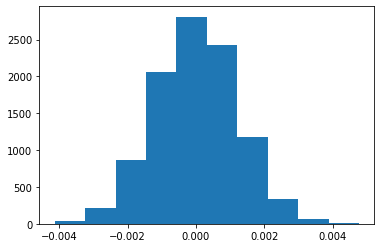

In [31]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs)
plt.show()

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [32]:
control_ctr = df2.query('group == "control"')['converted'].mean()
treatment_ctr = df2.query('group == "treatment"')['converted'].mean()
obs_diff = treatment_ctr - control_ctr
obs_diff

-0.0015782389853555567

<font color = 'mediumblue'> the observed conversion rate difference is 0.00158.</font>

In [33]:
p_val = (p_diffs > obs_diff).mean()
p_val

0.9049

<font color = 'mediumblue'> The p-value associated with the conversion rate difference is 0.905</font>

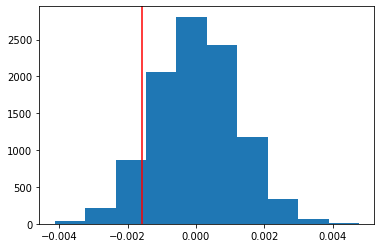

In [34]:
#plot the line for p-value
plt.hist(p_diffs);
plt.axvline(x = obs_diff,c = 'red');

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

<font color = 'mediumblue'>
- In part J, we calcualted the shadow area where p_diffs area(the simulated difference calculated) is greater than the observed convertion rate difference. (blue area right above the red line). The p_value is 0.905 <br>
- p_value is the probability obtaining the null hypothesis is rejected, if we orignially assume null hypothsis is correct. The higher p-value is, the higher probability we fail to reject null hypothesis. In this case, the p-value is greater than type I error rate (5%). Therefore we fail to reject null hypothesis. <br>
- Therefore, with probability 0.905 out of 1, the new page conversion rate is no greater than the old page conversion rate.<br>


l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [35]:
import statsmodels.api as sm

convert_old = df2.query('group == "control"')['converted'].sum()
convert_new = df2.query('group == "treatment"')['converted'].sum()
n_old = df_control.shape[0]
n_new = df_treatment.shape[0]

In [36]:
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [37]:
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_old,convert_new]),np.array([n_old,n_new]),alternative = 'smaller')
z_score, p_value

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

<font color = 'mediumblue'>
    
- Z_score is the number of standard deviation from the mean. If a z_score is 0, indicates that the data point is identical to the mean score. With 95% of all elements the z_score should above 1.96. In our case z_score smaller than 1.96, therefore it's not statistcally significant to reject null hypothesis. <br>
    
- Calculated p_value is 0.905 > 0.05. We cannot reject null hypothesis and conclude the new page is no better conversions than old page. <br>
- In part j and k, we calc p-values are both around 0.905, all far above 0.05, and with the calcuated Z-score, aline the findings we cannot reject null hypothesis. <br> </font>

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

<font color = 'mediumblue'>We could use logistic regression model. Because the output result is categorical variable with binomial distribution, we could use OLS to calc the independent variable regression to predict the log odds of the conversion.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [38]:
# Creat a copy of df2 data used for add more columns and build model.
df3 = df2.copy()
df3.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [39]:
# add intercept and convert group to dummy variables. Drop the unnecessary columns
df3['intercept'] = 1
df3[['control','ab_page']] = pd.get_dummies(df3['group'])
df3.drop(columns = ['control'], inplace = True)
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [40]:
logit_model = sm.Logit(df3['converted'],df3[['intercept','ab_page']])
result = logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [41]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 16 Dec 2019   Pseudo R-squ.:               8.077e-06
Time:                        14:39:20   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

In [42]:
# exponentiate the coefficiant 
np.exp(1.9888),np.exp(0.015)

(7.3067603868728614, 1.015113064615719)

<font color = 'mediumblue'> Here's exponetiate transferred coefficiant. </font>

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

<font color = 'mediumblue'>
p-value is 0.19 for ab_page: <br>
- compared with previous section, which p_values are 0.906 and 0.905. Logistic regression model p-value difference most due to null hypothesis is different.<br> 
- In part II, the null hypothesis is old page is better or equal conversion compared with new page (one-side direction). In part III, the null hypothesis is old page is equal conversion rate compared with new page (two-side direction)<br>
- If we need to get equal p-value from part III to match part II hypothesis. We could calc (1-0.19/2) = 0.905. This is same with part II.<br>

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**<br>
<font color = 'mediumblue'>
Some other factors could be put into regression models are: <br>
- demographic factor: such as age / gender / country / language / education level / income level / occupation etc.<br>
- User behavorial data : such as referal channel / device / interests etc.<br>

The side effect of add more factors into regression model is that more variables hard to meet the qualification for multiple regression and might potentially cause model inaccurate and misleading due to:<br>
- Non-linearity of the response-predictor relationships<br>
- Correlation of error terms<br>
- Non-constant Variance and not normally distributed<br>
- Outliers and high leverage points<br>
- Muticollinearity

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [43]:
# Read countries data
countries = pd.read_csv('countries.csv')
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [44]:
#Join contries data with df data with unique user id.
df_new = df3.merge(countries,on = 'user_id',how = 'inner')
df_new.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [45]:
# Convert countries to dummy variables, use CA as baseline country.
df_new[['CA','UK','US']] = pd.get_dummies(df_new['country'])
df_new = df_new.drop(columns = ['country','CA'])
df_new.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0,1


In [46]:
# build logistic regression model for multi variables
logit_model2 = sm.Logit(df_new['converted'],df_new[['intercept','ab_page','UK','US']])
result2 = logit_model2.fit()
result2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Mon, 16 Dec 2019   Pseudo R-squ.:               2.323e-05
Time:                        14:39:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

In [47]:
# exponetiate the coefficient to interpret the result
np.exp(0.0149),np.exp(0.0506),np.exp(0.0408)

(1.0150115583846535, 1.0519020483004984, 1.0416437559600236)

<font color = 'mediumblue'>
Interpret the Multiple Logistic Regression model result: <br>
- For each one unit increase in new_page, conversion rate is 1.015 times as likely holding all other variables constant<br>
- Compared with CA users, the UK user conversion rate is 1.05 times as likely, holding all other variables constant<br>
- Compared with CA users, the US user conversion rate is 1.04 times as likely, holding all other variables constant<br>

Non of the p-value is significant, therefore we cannot reject null hypothesis, the new_page is not significantly difference than the old_page.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [48]:
# Create interaction columns between page and country
df_new2 = df_new.copy()
df_new2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,0,1


In [49]:
df_new2.drop(columns = ['timestamp','group','landing_page'],inplace = True)
df_new2['UK_ab_page'] = df_new2['UK'] * df_new2['ab_page']
df_new2['US_ab_page'] = df_new2['US'] * df_new2['ab_page']
df_new2.head()

,user_id,converted,intercept,ab_page,UK,US,UK_ab_page,US_ab_page
0,851104,0,1,0,0,1,0,0
1,804228,0,1,0,0,1,0,0
2,661590,0,1,1,0,1,0,1
3,853541,0,1,1,0,1,0,1
4,864975,1,1,0,0,1,0,0


In [50]:
# check the correlation matrix for all variables
df_new2.drop(['intercept'],axis = 1).corr()

,user_id,converted,ab_page,UK,US,UK_ab_page,US_ab_page
user_id,1.000000,0.001769,-0.001745,-0.002060,0.001187,-0.002814,0.000217
converted,0.001769,1.000000,-0.002432,0.001772,-0.000237,0.001827,-0.002563
ab_page,-0.001745,-0.002432,1.000000,-0.002092,0.001216,0.376626,0.734811
UK,-0.002060,0.001772,-0.002092,1.000000,-0.881979,0.653496,-0.423595
US,0.001187,-0.000237,0.001216,-0.881979,1.000000,-0.576370,0.480278
UK_ab_page,-0.002814,0.001827,0.376626,0.653496,-0.576370,1.000000,-0.276818
US_ab_page,0.000217,-0.002563,0.734811,-0.423595,0.480278,-0.276818,1.000000


<font color ='mediumblue'>From above correlation-covariance matrix, we can see 'US_ab_page' and 'ab_page' have strong relationship 0.735. This indicates US visitors would more likely to shown to new_page.

In [51]:
#Then let's quickly fit a logistic regression model for interaction variables.
logit_model3 = sm.Logit(df_new2['converted'],df_new2[['intercept','ab_page','UK','US','UK_ab_page','US_ab_page']])
result3 = logit_model3.fit()
result3.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 16 Dec 2019   Pseudo R-squ.:               3.482e-05
Time:                        14:39:22   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page       -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK             0.0118      0.040      0.296      0.767      -0.066       0.090
US             0.0175      0.038      0.465      0.642      -0.056       0.091
UK_ab_page     0.0783      0.057      1.378      0.168      -0.033       0.190
US_ab_page     0.0469      0.054      0.872      0.383      -0.059       0.152
==============================================================================
"""

<font color = 'mediumblue'>We can see non of the p-value is significant, also approves we cannot reject null hypothesis and there's no need to add interaction terms in the model

<a id='future'></a>
# Future Improvement 
<font color = 'mediumblue'>
In the future, we improve our results by: <br>
    - Include more data to see if there's any correlation between conversion rate and user: such as user's demographic data<br>
    - Go further analysis which part of the new page could be improved to better convert users.<br>
    - Try to add time analysis, to see if user's conversion rate is associate with the time they converted.<br>
    - Try use different models to get conclusion, such as random forest, SVM to see if the result would be different based on difference segments of the users.<br>